In [1]:
import torch
import torch.nn as nn
import os
import math

In [34]:
class MGP(nn.Module):
    def __init__(self, X_L, y_L, X_H, y_H, feature_dim):
        super(MGP, self).__init__()
        self.D = X_H.shape[1]
        self.X_L = X_L
        self.y_L = y_L
        self.X_H = X_H
        self.y_H = y_H
        
        self.feature_dim = feature_dim
        hidden_dim = 2 * feature_dim
        self.Linear1 = nn.Linear(self.D, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, feature_dim)
        self.ReLU = nn.Sigmoid()
        self.hyp = self.init_params()
        print("Total number of parameters: %d" % (self.hyp.shape[0]))
        self.jitter = 1e-8
        
    def feature_get(self, X):
        hidden_layer = self.Linear1(X)
        ReLU_layer = self.ReLU(hidden_layer)
        output_layer = self.Linear2(ReLU_layer)
        return output_layer
    
    def init_params(self):
        hyp = torch.log(torch.ones(self.feature_dim + 1))
#         hyp = torch.log(torch.ones(self.D + 1))
        self.idx_theta_L = torch.arange(hyp.shape[0])

        hyp = torch.cat([hyp, torch.log(torch.ones(self.feature_dim + 1))])
#         hyp = torch.cat([hyp, torch.log(torch.ones(self.D + 1))])
        self.idx_theta_H = torch.arange(self.idx_theta_L[-1] + 1, hyp.shape[0])

        rho = torch.tensor([1.0])
        logsigma_n = torch.tensor([-4.0, -4.0])
        hyp = torch.cat([hyp, rho, logsigma_n])
        hyp = torch.nn.Parameter(hyp, requires_grad=True)
        return hyp
    
    def kernel(self, x, xp, hyp):
        output_scale = torch.exp(hyp[0])
        lengthscales = torch.exp(hyp[1:])
        diffs = torch.unsqueeze(x / lengthscales, 1) - \
                torch.unsqueeze(xp / lengthscales, 0)
        return output_scale * torch.exp(-0.5 * torch.sum(diffs ** 2, axis=2))
    
    def likelihood(self, hyp):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H

        y = torch.cat((y_L, y_H), dim=0)

        NL = y_L.shape[0]
        NH = y_H.shape[0]
        N = y.shape[0]

        rho = hyp[-3]
        logsigma_n_L = hyp[-2]
        logsigma_n_H = hyp[-1]
        sigma_n_L = torch.exp(logsigma_n_L)
        sigma_n_H = torch.exp(logsigma_n_H)

        theta_L = hyp[self.idx_theta_L]
        theta_H = hyp[self.idx_theta_H]

        K_LL = self.kernel(X_L, X_L, theta_L) + torch.eye(NL) * sigma_n_L
        K_LH = rho * self.kernel(X_L, X_H, theta_L)
        K_HH = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H) + torch.eye(NH) * sigma_n_H
        K = torch.cat((torch.cat((K_LL, K_LH), dim=1),
                          torch.cat((K_LH.T, K_HH), dim=1)), dim=0)
        L = torch.cholesky(K + torch.eye(N) * self.jitter)
        
        self.L = L

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        NLML = 0.5 * torch.matmul(y.T, alpha) + \
               torch.sum(torch.log(torch.diag(L))) + 0.5 * np.log(2. * np.pi) * N
        return NLML[0, 0]
    
    def forward(self):
        result = self.likelihood(self.hyp)
        return result
    
    def predict(self, X_star_raw):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H
        L = self.L
        X_star = self.feature_get(X_star_raw)
#         X_star = X_star_raw

        y = torch.cat((y_L, y_H), dim=0)

        rho = self.hyp[-3]
        theta_L = self.hyp[self.idx_theta_L]
        theta_H = self.hyp[self.idx_theta_H]

        psi1 = rho * self.kernel(X_star, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_star, X_H, theta_L) + \
               self.kernel(X_star, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        pred_u_star = torch.matmul(psi, alpha)

        beta = torch.solve(torch.solve(psi.T,L).solution, L.T).solution
        var_u_star = rho ** 2 * self.kernel(X_star, X_star, theta_L) + \
                     self.kernel(X_star, X_star, theta_H) - torch.matmul(psi, beta)

        return pred_u_star, var_u_star
    
    def callback(self, params):
        print("Log likelihood {}".format(self.likelihood(params)))

In [35]:
import autograd.numpy as np
import torch
import matplotlib.pyplot as plt
from pyDOE import lhs
from Handwritten_Deep_Multi_Gaussian import Multifidelity_GP
from sklearn.metrics import r2_score
%matplotlib inline  
np.random.seed(1234)

In [36]:
def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [37]:
N_H = 3
N_L = 8
D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
noise_L = 0.00
noise_H = 0.00

Normalize_input_data = 1
Normalize_output_data = 1

In [38]:
# Training data    
X_L = np.loadtxt('./dataset/x_train_low.txt').reshape(-1,32)
y_L = (np.loadtxt('./dataset/y_train_low.txt')*1e4).reshape(-1,1)

X_H = np.loadtxt('./dataset/x_train_high.txt').reshape(-1,32)
y_H = np.loadtxt('./dataset/y_train_high.txt').reshape(-1,1)

# Test data
X_star = np.loadtxt('./dataset/x_test_high.txt').reshape(-1,32)
y_star = np.loadtxt('./dataset/y_test_high.txt').reshape(-1,1)

#  #  Normalize Input Data
# if Normalize_input_data == 1:
#     X = np.vstack((X_L,X_H))
# #     X=X.T
#     X_m = np.mean(X, axis = 0)
#     X_s = np.std(X, axis = 0)   
#     X_L = Normalize(X_L, X_m, X_s)
#     X_H = Normalize(X_H, X_m, X_s)
#     lb = Normalize(lb, X_m, X_s)
#     ub = Normalize(ub, X_m, X_s)
#     X_star = Normalize(X_star, X_m, X_s)

# #  Normalize Output Data
# if Normalize_output_data == 1:
#     y = np.vstack((y_L,y_H))
# #     y=y.T
#     y_m = np.mean(y, axis = 0)
#     y_s = np.std(y, axis = 0)   
#     y_L = Normalize(y_L, y_m, y_s)
#     y_H = Normalize(y_H, y_m, y_s)
#     y_star = Normalize(y_star, y_m, y_s)
    

# # Plot the training data
# plt.figure(facecolor='w')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=16)
# plt.plot(X_H,y_H,'bo', markersize = 12, alpha = 0.5, label = "Data")
# plt.plot(X_L,y_L,'ms', markersize = 8, alpha = 0.5, label = "Data")
# plt.title("Training data")
# ax = plt.gca()
# # ax.set_xlim([lb[0], ub[0]])
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')

In [39]:
X_L=X_L.reshape(-1,32)
X_H=X_H.reshape(-1,32)
y_L=y_L.reshape(-1,1)
y_H=y_H.reshape(-1,1)
feature_dim = 48

X_L=torch.from_numpy(X_L).float()
X_H=torch.from_numpy(X_H).float()
y_L=torch.from_numpy(y_L).float()
y_H=torch.from_numpy(y_H).float()

In [40]:
model = MGP(X_L, y_L, X_H, y_H,feature_dim)

Total number of parameters: 101


In [50]:
optimizer = torch.optim.Rprop(model.parameters(), lr=1e-3)
# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [66]:
epoches = 500

for e in range(epoches):
    optimizer.zero_grad()
    loss = model()
#     if loss<0:
#         break
    if (e)%10==0:
        print(f'epoch: {e}  loss: {loss.item()}')
    loss.backward()
    optimizer.step()

epoch: 0  loss: -233.255126953125
epoch: 10  loss: -237.437744140625
epoch: 20  loss: -241.860595703125
epoch: 30  loss: -246.29150390625
epoch: 40  loss: -250.568359375
epoch: 50  loss: -253.851806640625
epoch: 60  loss: -258.3272705078125
epoch: 70  loss: -263.137451171875
epoch: 80  loss: -267.73291015625
epoch: 90  loss: -271.718994140625
epoch: 100  loss: -275.301513671875
epoch: 110  loss: -279.969482421875
epoch: 120  loss: -284.28173828125
epoch: 130  loss: -287.7032470703125
epoch: 140  loss: -292.4754638671875
epoch: 150  loss: -296.76953125
epoch: 160  loss: -297.832275390625
epoch: 170  loss: -304.54248046875
epoch: 180  loss: -309.068359375
epoch: 190  loss: -313.4796142578125
epoch: 200  loss: -315.42822265625
epoch: 210  loss: -321.228759765625
epoch: 220  loss: -325.7860107421875
epoch: 230  loss: -328.622314453125
epoch: 240  loss: -334.0111083984375
epoch: 250  loss: -338.42333984375
epoch: 260  loss: -341.4384765625
epoch: 270  loss: -346.1064453125
epoch: 280  loss:

In [67]:
X_star=torch.from_numpy(np.array(X_star).reshape(-1,32)).float()

In [68]:
# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [69]:
y_pred, y_var = model.predict(X_star)
y_pred, y_var = y_pred.detach().numpy(), y_var.detach().numpy()

Relative L2 error u: 7.983579e-02
r2 socre: -0.14088345454353002
[[31.1779]
 [29.1824]
 [26.4095]
 [26.9644]
 [30.09  ]
 [26.837 ]
 [25.28  ]
 [31.4606]
 [30.1555]] [[29.900288]
 [30.106806]
 [29.46209 ]
 [29.809822]
 [27.025227]
 [27.587275]
 [28.026257]
 [28.403618]
 [29.449656]]
[0.01366234 0.03063536 0.08816314 0.01715887 0.11463714 0.15863419
 0.09159243 0.0345614  0.02928162]


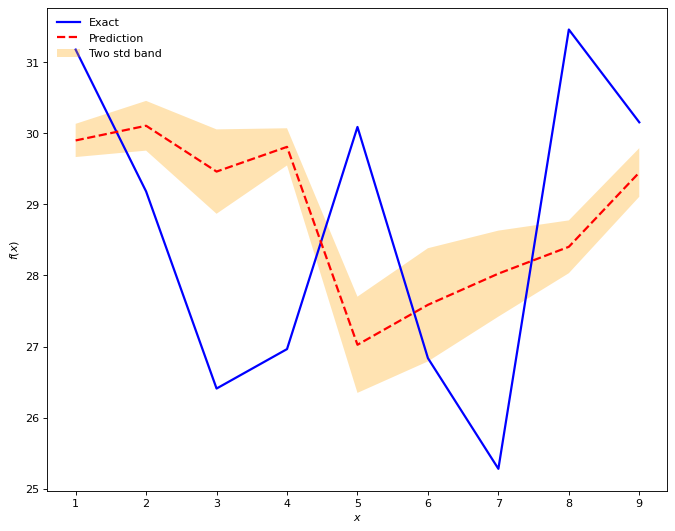

In [71]:
file_write_obj = open("14.AdamMax-without-norm-1500-epoch-feature48-lr1e-4.txt", 'w')
# for var in mylist:
#     file_write_obj.writelines(var)
#     file_write_obj.write('\n')


# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

file_write_obj.write('Relative L2 error')
file_write_obj.write(str(error))
file_write_obj.write('\n')

index=[1,2,3,4,5,6,7,8,9]
y_pred=np.array(y_pred)
y_star=np.array(y_star)

print("r2 socre:",r2_score(y_star,y_pred))

file_write_obj.write('r2 socre')
file_write_obj.writelines(str(r2_score(y_star,y_pred)))
file_write_obj.write('\n')

print(y_star, y_pred)
file_write_obj.write('Exact')
file_write_obj.write(str(y_star))
file_write_obj.write('\n')

file_write_obj.write('Predict')
file_write_obj.write(str(y_pred))
file_write_obj.write('\n')

y_var_new=np.abs(np.diag(y_var))
print(y_var_new)

file_write_obj.write('std')
file_write_obj.write(str(y_var_new))
file_write_obj.write('\n')

# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star, 'b-', label = "Exact", linewidth=2)
plt.plot(index, y_pred, 'r--', label = "Prediction", linewidth=2)


lower = np.array(y_pred - 2.0*np.sqrt(y_var_new[:,None]))
upper = np.array(y_pred + 2.0*np.sqrt(y_var_new[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.savefig("14.AdamMax-without-norm-1500-epoch-feature48-lr1e-4.png")
file_write_obj.close()


In [72]:
y_pred2, y_var2 = model.predict(X_H)
y_pred2, y_var2 = y_pred2.detach().numpy(), y_var2.detach().numpy()

Relative L2 error u: 7.983579e-02
r2 socre: 0.9998448979688125
[[23.59  ]
 [29.0747]
 [26.14  ]
 [27.8161]
 [30.3172]
 [26.5041]
 [25.4043]
 [29.11  ]
 [24.28  ]
 [27.7186]
 [31.0396]
 [28.8246]
 [25.66  ]
 [29.6   ]
 [25.4395]
 [27.759 ]
 [26.68  ]
 [25.7   ]
 [22.0351]
 [26.9236]
 [28.3551]] [[23.62714 ]
 [29.089432]
 [26.178679]
 [27.823448]
 [30.328943]
 [26.461147]
 [25.36077 ]
 [29.162502]
 [24.28244 ]
 [27.753958]
 [31.037724]
 [28.83717 ]
 [25.6884  ]
 [29.638443]
 [25.45684 ]
 [27.754002]
 [26.680668]
 [25.739845]
 [22.022667]
 [26.910324]
 [28.370628]]
[0.00254562 0.00025116 0.00400914 0.00084216 0.00023159 0.00065083
 0.00157729 0.00267097 0.00033732 0.00073684 0.00114753 0.00147108
 0.00156089 0.00103273 0.00122631 0.00186462 0.00286726 0.0054036
 0.00359194 0.00103043 0.00445556]


Text(0, 0.5, '$f(x)$')

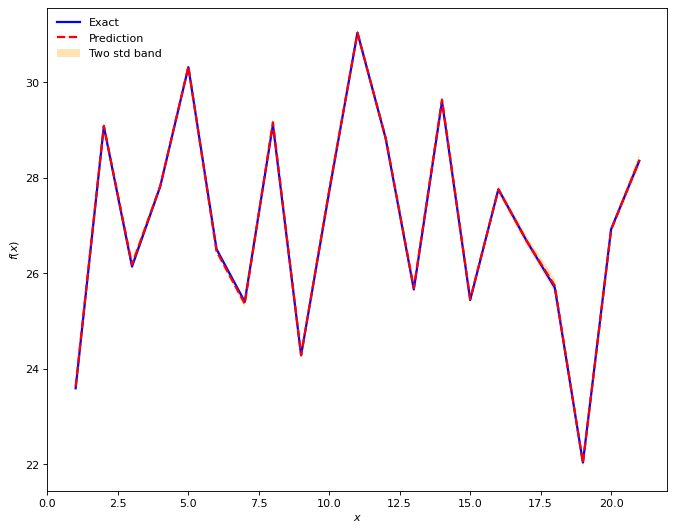

In [73]:

# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))


index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
y_pred2=np.array(y_pred2)
y_star2=np.array(y_H)

print("r2 socre:",r2_score(y_star2,y_pred2))

print(y_star2, y_pred2)

y_var_new=abs(y_var2.mean(axis=1))*9
print(y_var_new)


# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star2, 'b-', label = "Exact", linewidth=2)
plt.plot(index, y_pred2, 'r--', label = "Prediction", linewidth=2)


lower = np.array(y_pred2 - 2.0*np.sqrt(y_var_new[:,None]))
upper = np.array(y_pred2 + 2.0*np.sqrt(y_var_new[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')


